# Import Libraries

In [ ]:
# Data manipulation and analysis
import pandas as pd

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Feature scaling
from sklearn.preprocessing import StandardScaler

# Hierarchical clustering tools
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.cluster import AgglomerativeClustering

# Clustering evaluation metrics
from sklearn.metrics import silhouette_score, davies_bouldin_score

# Dimensionality reduction
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Load Data

In [ ]:
# Load the dataset
df = pd.read_csv('/content/Mall_Customers.csv')

## Load and Initial Data Cleaning

In [ ]:
# Display the first 5 rows
print("First 5 rows of the DataFrame:")
print(df.head())

# Check for missing values
print("\nMissing values in each column:")
print(df.isnull().sum())

# Print a concise summary of the DataFrame
print("\nDataFrame Info:")
df.info()

First 5 rows of the DataFrame:
   CustomerID   Genre  Age  Annual Income (k$)  Spending Score (1-100)
0           1    Male   19                  15                      39
1           2    Male   21                  15                      81
2           3  Female   20                  16                       6
3           4  Female   23                  16                      77
4           5  Female   31                  17                      40

Missing values in each column:
CustomerID                0
Genre                     0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Genre                   200 non-null    object
 2   Age                     

## Exploratory Data Analysis (EDA)

In [ ]:
print("\nDescriptive statistics for the dataset:")
print(df.describe())


Descriptive statistics for the dataset:
       CustomerID         Age  Annual Income (k$)  Spending Score (1-100)
count  200.000000  200.000000          200.000000              200.000000
mean   100.500000   38.850000           60.560000               50.200000
std     57.879185   13.969007           26.264721               25.823522
min      1.000000   18.000000           15.000000                1.000000
25%     50.750000   28.750000           41.500000               34.750000
50%    100.500000   36.000000           61.500000               50.000000
75%    150.250000   49.000000           78.000000               73.000000
max    200.000000   70.000000          137.000000               99.000000


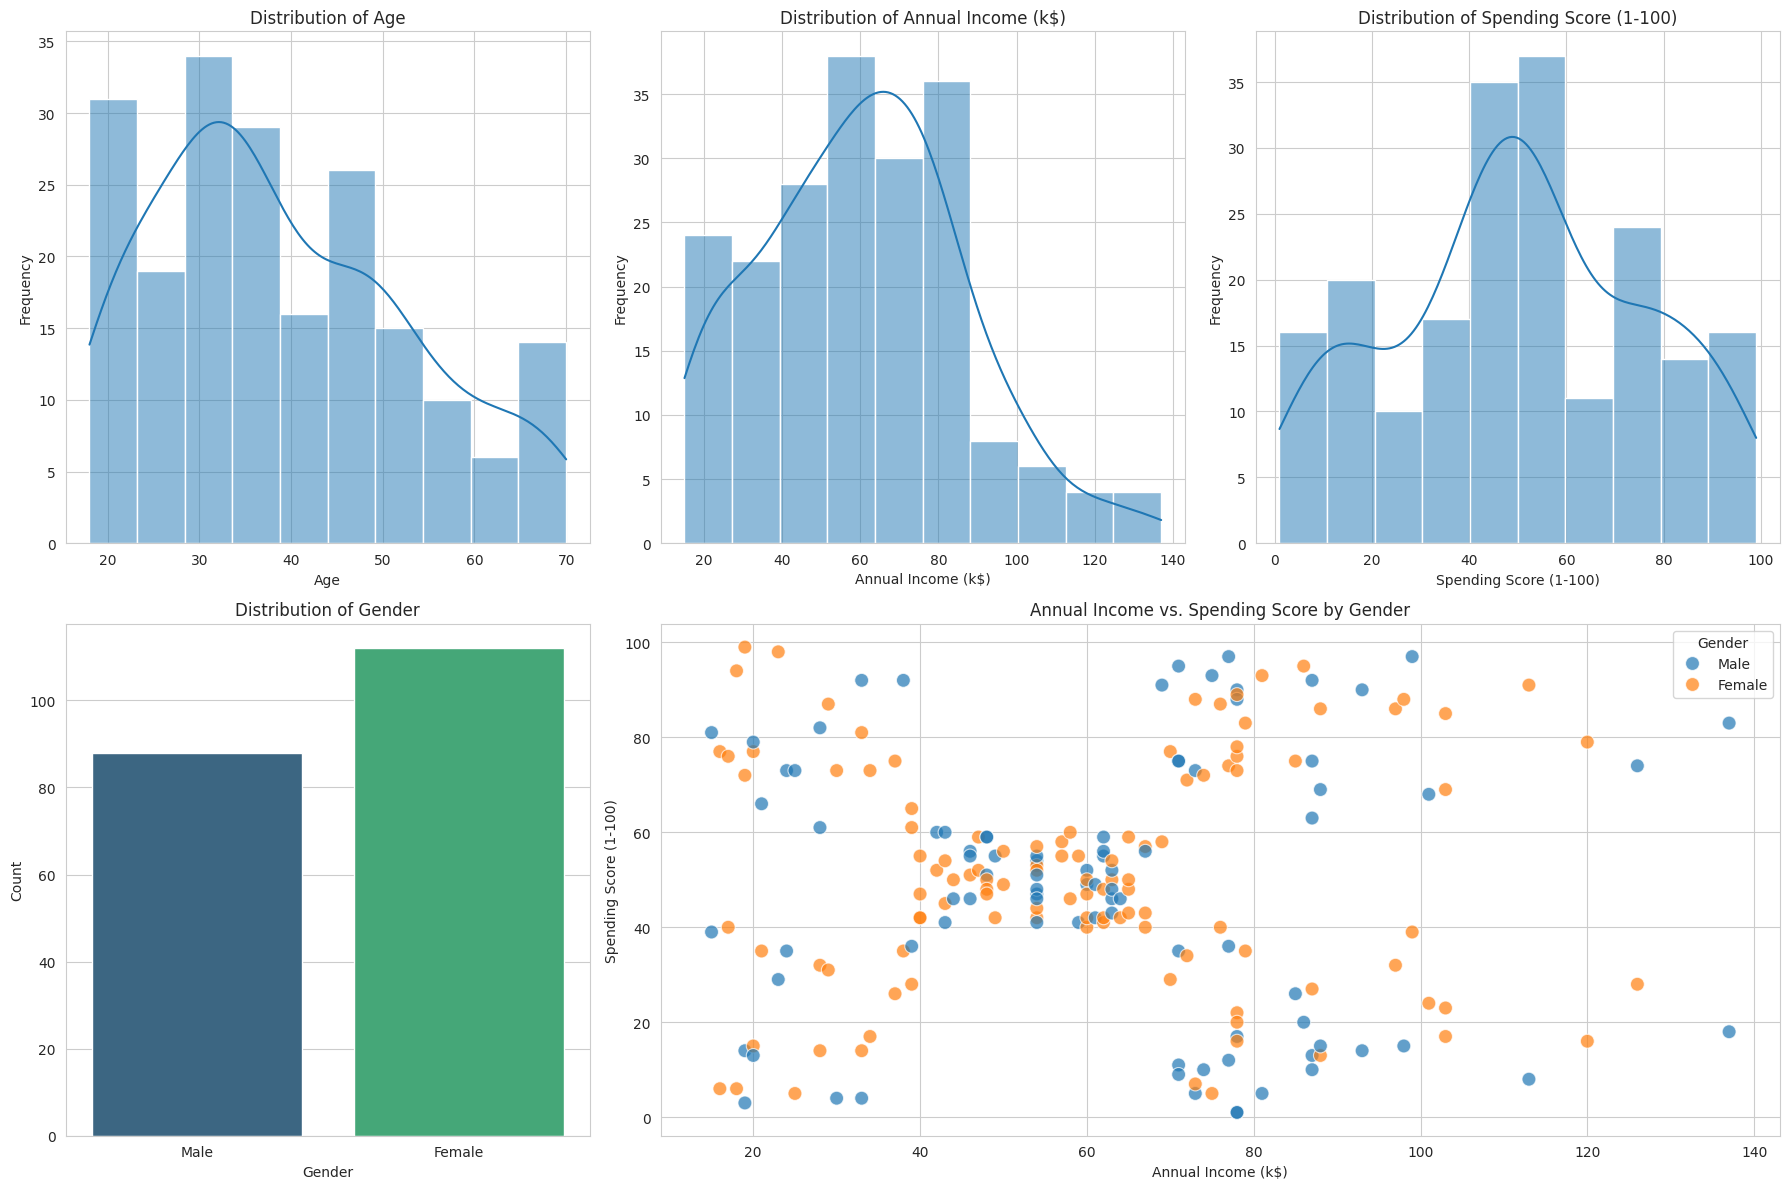

In [ ]:
# Set style for better aesthetics
sns.set_style("whitegrid")

# Create a figure to hold multiple plots
plt.figure(figsize=(18, 12))

# Histogram for Age
plt.subplot(2, 3, 1) # 2 rows, 3 columns, 1st plot
sns.histplot(df['Age'], bins=10, kde=True)
plt.title('Distribution of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')

# Histogram for Annual Income
plt.subplot(2, 3, 2) # 2 rows, 3 columns, 2nd plot
sns.histplot(df['Annual Income (k$)'], bins=10, kde=True)
plt.title('Distribution of Annual Income (k$)')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Frequency')

# Histogram for Spending Score
plt.subplot(2, 3, 3) # 2 rows, 3 columns, 3rd plot
sns.histplot(df['Spending Score (1-100)'], bins=10, kde=True)
plt.title('Distribution of Spending Score (1-100)')
plt.xlabel('Spending Score (1-100)')
plt.ylabel('Frequency')

# Count plot for Gender
plt.subplot(2, 3, 4) # 2 rows, 3 columns, 4th plot
sns.countplot(x='Genre', data=df, palette='viridis', hue='Genre', legend=False)
plt.title('Distribution of Gender')
plt.xlabel('Gender')
plt.ylabel('Count')

# Scatter plot of Annual Income vs. Spending Score, colored by Gender
plt.subplot(2, 3, (5, 6)) # Spanning across 5th and 6th plot positions
sns.scatterplot(x='Annual Income (k$)', y='Spending Score (1-100)', hue='Genre', data=df, s=100, alpha=0.7)
plt.title('Annual Income vs. Spending Score by Gender')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.legend(title='Gender')

plt.tight_layout() # Adjust layout to prevent overlapping titles/labels
plt.show()

## Feature Engineering

In [ ]:
# Identify numerical features for scaling
numerical_features = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)', 'income_to_spending_ratio']

# Exclude 'CustomerID' as it is an identifier, and 'Age Group', 'Gender_Female', 'Gender_Male' as they are not continuous numerical features to be scaled this way
# Also ensure 'CustomerID' is not included if it implicitly got into numerical_features based on dtype

# Create a copy of the dataframe to avoid SettingWithCopyWarning
df_scaled_features = df[numerical_features].copy()

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the selected numerical features
df_scaled = scaler.fit_transform(df_scaled_features)

# Convert the scaled array back to a DataFrame with original column names
df_scaled = pd.DataFrame(df_scaled, columns=numerical_features)

# Display the head of the newly created df_scaled DataFrame
print("Head of the scaled numerical features DataFrame:")
print(df_scaled.head())

# Optionally, add the scaled features back to the main DataFrame or keep separate for clustering
# For clustering, we often use only the scaled features, or combine them with other processed features.
# Let's keep a combined DataFrame for later, including CustomerID, Gender, and scaled features.

df_processed = df.copy()
df_processed[numerical_features] = df_scaled

print("\nHead of the combined processed DataFrame with scaled numerical features:")
print(df_processed.head())

Head of the scaled numerical features DataFrame:
        Age  Annual Income (k$)  Spending Score (1-100)  \
0 -1.424569           -1.738999               -0.434801   
1 -1.281035           -1.738999                1.195704   
2 -1.352802           -1.700830               -1.715913   
3 -1.137502           -1.700830                1.040418   
4 -0.563369           -1.662660               -0.395980   

   income_to_spending_ratio  
0                 -0.440747  
1                 -0.485000  
2                 -0.000530  
3                 -0.479885  
4                 -0.431616  

Head of the combined processed DataFrame with scaled numerical features:
   CustomerID       Age  Annual Income (k$)  Spending Score (1-100)  \
0           1 -1.424569           -1.738999               -0.434801   
1           2 -1.281035           -1.738999                1.195704   
2           3 -1.352802           -1.700830               -1.715913   
3           4 -1.137502           -1.700830               

## Apply Hierarchical Clustering

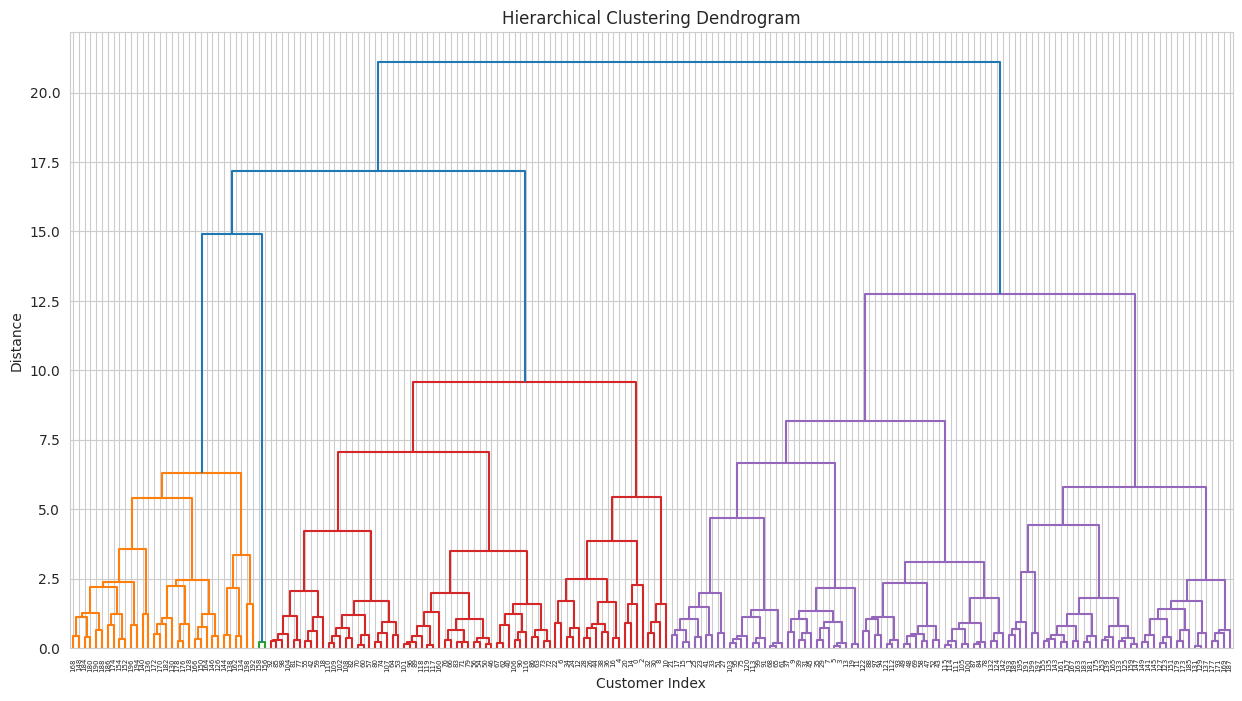

In [ ]:
# Compute the linkage matrix using the 'ward' method
linked = linkage(X, method='ward')

# Plot the dendrogram
plt.figure(figsize=(15, 8))
dendrogram(linked,
           orientation='top',
           distance_sort='descending',
           show_leaf_counts=True)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Customer Index')
plt.ylabel('Distance')
plt.show()


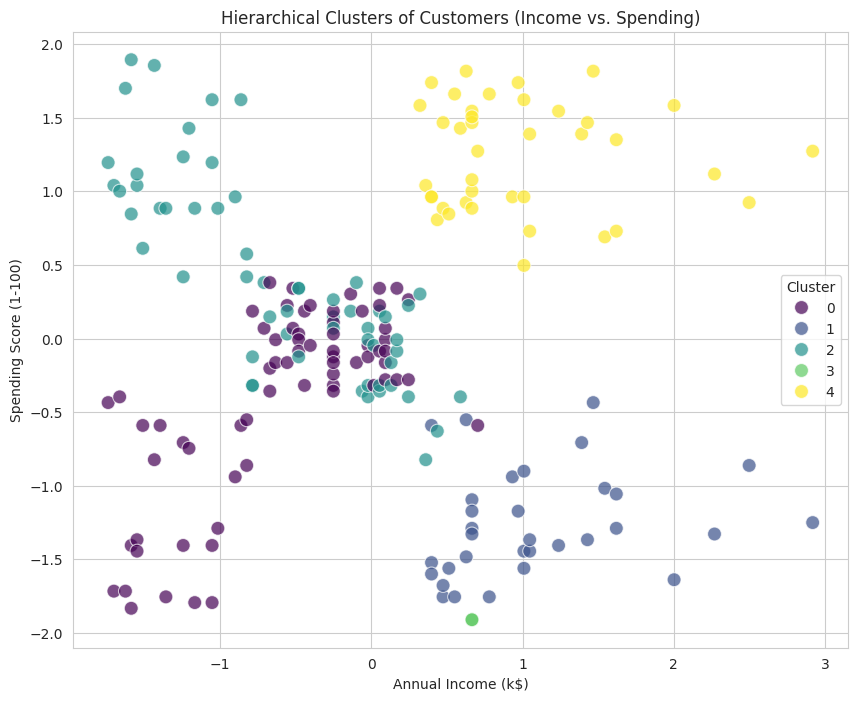

First 5 rows of df_processed with Hierarchical_Cluster labels:
   CustomerID       Age  Annual Income (k$)  Spending Score (1-100)  \
0           1 -1.424569           -1.738999               -0.434801   
1           2 -1.281035           -1.738999                1.195704   
2           3 -1.352802           -1.700830               -1.715913   
3           4 -1.137502           -1.700830                1.040418   
4           5 -0.563369           -1.662660               -0.395980   

   income_to_spending_ratio Age Group  Gender_Female  Gender_Male  \
0                 -0.440747     Young          False         True   
1                 -0.485000     Young          False         True   
2                 -0.000530     Young           True        False   
3                 -0.479885     Young           True        False   
4                 -0.431616     Adult           True        False   

   KMeans_Cluster  Hierarchical_Cluster  DBSCAN_Cluster  
0               4                    

In [ ]:
# Initialize AgglomerativeClustering model with n_clusters=5
# Note: 'affinity' parameter was renamed to 'metric' in scikit-learn 1.2. Please adjust if using an older version.
hierarchical_cluster = AgglomerativeClustering(n_clusters=5, metric='euclidean', linkage='ward')

# Fit the model and get cluster labels
df_processed['Hierarchical_Cluster'] = hierarchical_cluster.fit_predict(X)

# Create a scatter plot of 'Annual Income (k$)' vs. 'Spending Score (1-100)', colored by 'Hierarchical_Cluster'
plt.figure(figsize=(10, 8))
sns.scatterplot(x='Annual Income (k$)', y='Spending Score (1-100)', hue='Hierarchical_Cluster', data=df_processed, palette='viridis', s=100, alpha=0.7)

# Add a title to the plot
plt.title('Hierarchical Clusters of Customers (Income vs. Spending)')

# Label the x-axis and y-axis
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')

# Display the plot with a legend for the clusters
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

print("First 5 rows of df_processed with Hierarchical_Cluster labels:")
print(df_processed.head())

## Evaluate Clustering Model

In [ ]:
# Evaluate Hierarchical Clustering
hierarchical_labels = df_processed['Hierarchical_Cluster']

# Silhouette Score for Hierarchical Clustering
silhouette_hierarchical = silhouette_score(X, hierarchical_labels)
print(f"Hierarchical Clustering Silhouette Score: {silhouette_hierarchical:.4f}")

# Davies-Bouldin Index for Hierarchical Clustering
davies_bouldin_hierarchical = davies_bouldin_score(X, hierarchical_labels)
print(f"Hierarchical Clustering Davies-Bouldin Index: {davies_bouldin_hierarchical:.4f}")

Hierarchical Clustering Silhouette Score: 0.3098
Hierarchical Clustering Davies-Bouldin Index: 1.0070


## Dimensionality Reduction with PCA and t-SNE for Visualizationls.

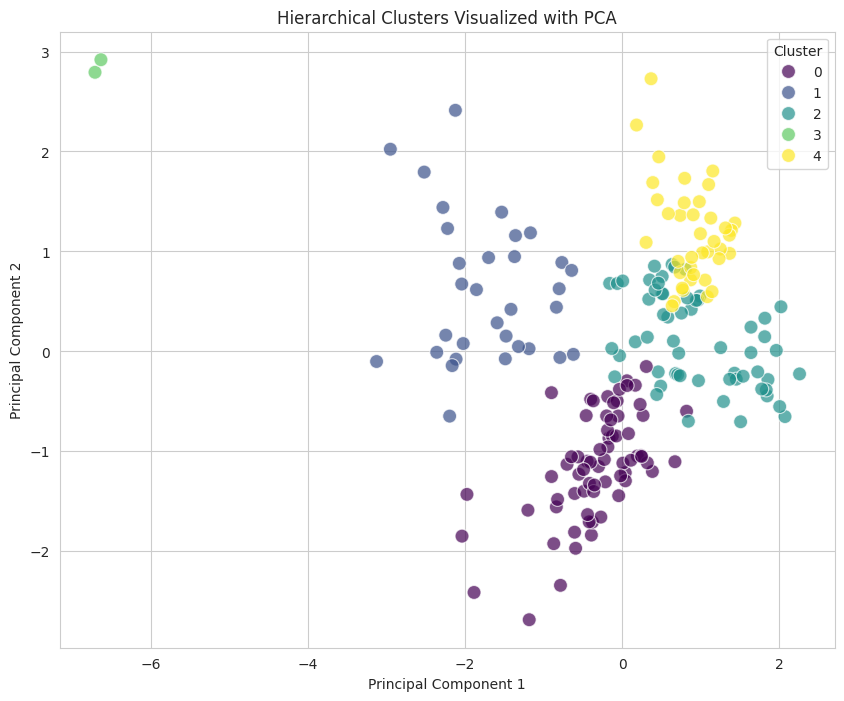

First 5 rows of PCA-reduced data with cluster labels:
   principal_component_1  principal_component_2  Cluster
0               0.818372              -0.598406        0
1               1.853612              -0.281847        2
2              -0.168660              -0.867533        0
3               1.843046              -0.445374        2
4               0.670582              -1.103702        0


In [ ]:
# Identify the best performing model for visualization
# Based on evaluation, Hierarchical Clustering had the best Silhouette and Davies-Bouldin scores.
best_model_labels = df_processed['Hierarchical_Cluster']

# Apply PCA to reduce dimensions to 2
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X)

# Create a DataFrame for PCA results
df_pca = pd.DataFrame(data = X_pca, columns = ['principal_component_1', 'principal_component_2'])

# Add cluster labels to the PCA DataFrame
df_pca['Cluster'] = best_model_labels

# Visualize the clusters using PCA components
plt.figure(figsize=(10, 8))
sns.scatterplot(x='principal_component_1', y='principal_component_2', hue='Cluster', data=df_pca, palette='viridis', s=100, alpha=0.7)
plt.title('Hierarchical Clusters Visualized with PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

print("First 5 rows of PCA-reduced data with cluster labels:")
print(df_pca.head())

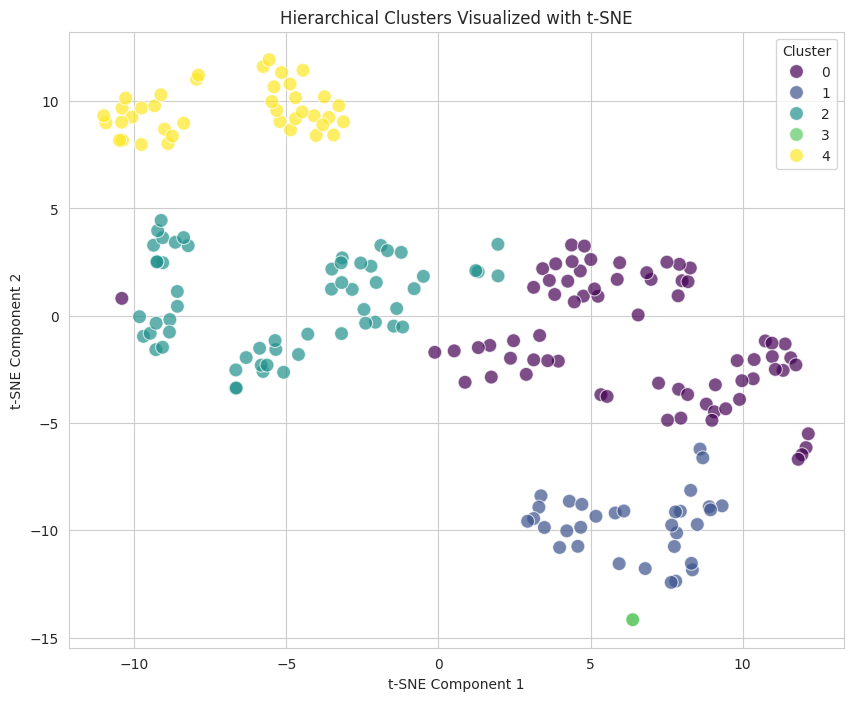

First 5 rows of t-SNE-reduced data with cluster labels:
   tsne_component_1  tsne_component_2  Cluster
0        -10.406135          0.811227        0
1         -9.695848         -0.959502        2
2          0.875599         -3.099828        0
3         -5.765224         -2.596024        2
4         -0.118624         -1.703268        0


In [ ]:
# Apply t-SNE to reduce dimensions to 2
# It's recommended to first reduce dimensionality with PCA if the number of features is high
# For this dataset, PCA to 2 components was already done, but t-SNE is often applied to original or higher-dim PCA output.
# Let's apply t-SNE to the original scaled data (X) to get its own 2D representation.
tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=1000)
X_tsne = tsne.fit_transform(X)

# Create a DataFrame for t-SNE results
df_tsne = pd.DataFrame(data = X_tsne, columns = ['tsne_component_1', 'tsne_component_2'])

# Add cluster labels (from the best model, Hierarchical Clustering) to the t-SNE DataFrame
df_tsne['Cluster'] = best_model_labels

# Visualize the clusters using t-SNE components
plt.figure(figsize=(10, 8))
sns.scatterplot(x='tsne_component_1', y='tsne_component_2', hue='Cluster', data=df_tsne, palette='viridis', s=100, alpha=0.7)
plt.title('Hierarchical Clusters Visualized with t-SNE')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

print("First 5 rows of t-SNE-reduced data with cluster labels:")
print(df_tsne.head())

## Business Interpretation of Customer Segments

In [ ]:
# Create a DataFrame for interpretation using original features
df_interpretation = df.copy()

# Add Hierarchical_Cluster labels from df_processed
df_interpretation['Hierarchical_Cluster'] = df_processed['Hierarchical_Cluster']

# Add engineered features back to df_interpretation
df_interpretation['income_to_spending_ratio'] = df_processed['income_to_spending_ratio']
df_interpretation['Gender_Female'] = df_processed['Gender_Female']
df_interpretation['Gender_Male'] = df_processed['Gender_Male']

# Define the features to analyze for each cluster (original scales)
analysis_features_original = [
    'Age',
    'Annual Income (k$)',
    'Spending Score (1-100)',
    'income_to_spending_ratio',
    'Gender_Female',
    'Gender_Male'
]

# Group by 'Hierarchical_Cluster' and calculate the mean for the selected features
cluster_summary_original = df_interpretation.groupby('Hierarchical_Cluster')[analysis_features_original].mean()

print("Cluster Summary (Mean of Original Features by Hierarchical Cluster):\n")
print(cluster_summary_original)


Cluster Summary (Mean of Original Features by Hierarchical Cluster):

                            Age  Annual Income (k$)  Spending Score (1-100)  \
Hierarchical_Cluster                                                          
0                     52.000000           45.173913               39.956522   
1                     41.625000           89.156250               17.750000   
2                     25.931034           45.017241               60.517241   
3                     35.500000           78.000000                1.000000   
4                     32.692308           86.538462               82.128205   

                      income_to_spending_ratio  Gender_Female  Gender_Male  
Hierarchical_Cluster                                                        
0                                    -0.205378       0.565217     0.434783  
1                                     0.857105       0.437500     0.562500  
2                                    -0.329218       0.655172     0.

### Business Interpretation of Customer Segments (Hierarchical Clustering)

Based on the `cluster_summary_original` DataFrame, we can interpret the characteristics of each customer segment:

**Cluster Summary (Mean of Original Features by Hierarchical Cluster):**
```
                            Age  Annual Income (k$)  Spending Score (1-100)  \
Hierarchical_Cluster                                                          
0                     52.000000           45.173913               39.956522   
1                     41.625000           89.156250               17.750000   
2                     25.931034           45.017241               60.517241   
3                     35.500000           78.000000                1.000000   
4                     32.692308           86.538462               82.128205   

                      income_to_spending_ratio  Gender_Female  Gender_Male  
Hierarchical_Cluster                                                        
0                                    -0.205378       0.565217     0.434783  
1                                     0.857105       0.437500     0.562500  
2                                    -0.329218       0.655172     0.344828  
3                                     8.458231       0.000000     1.000000  
4                                    -0.284053       0.538462     0.461538  
```

**Interpretation of Segments:**

*   **Cluster 0: The Balanced Spenders (Older, Mid-Income)**
    *   **Profile:** This segment consists of older customers (average age 52) with a moderate annual income (45k$) and moderate spending scores (40). They are relatively balanced in gender distribution. Their income-to-spending ratio is slightly negative, indicating they might spend a good portion of their income but are not extravagant. They are likely established individuals who value quality and comfort.
    *   **Marketing Strategy:** Focus on loyalty programs, comfort-oriented products, and services that offer value for money. Target with promotions for home goods, mature fashion, health, and wellness products. In-store events and personalized recommendations could appeal to their stable shopping habits.

*   **Cluster 1: The High-Income Savers (Male-leaning)**
    *   **Profile:** These customers have a high average annual income (89k$) but a low spending score (18). Their average age is around 41. They have a high positive income-to-spending ratio, indicating they save a significant portion of their income. This segment is slightly male-leaning. They are likely financially savvy and careful with their purchases.
    *   **Marketing Strategy:** Emphasize high-value, durable, and investment-worthy products. Marketing should highlight long-term benefits, quality, and exclusivity. Avoid frequent discounts; instead, focus on premium experiences or limited-edition items. Financial services or investment-related products within the mall could also appeal.

*   **Cluster 2: The Young & Enthusiastic Spenders (Female-leaning, Mid-Income)**
    *   **Profile:** This cluster represents younger customers (average age 26) with moderate annual incomes (45k$) but high spending scores (61). They are predominantly female. Their income-to-spending ratio suggests they spend a good portion of what they earn. They are likely trend-conscious and enjoy shopping for leisure and social reasons.
    *   **Marketing Strategy:** Target with trendy fashion, entertainment, beauty products, and social experiences. Social media campaigns, influencer collaborations, and youth-oriented events would be effective. Offer student discounts or bundles to encourage frequent visits.

*   **Cluster 3: The Ultra-Low Spenders (Single Male, High-Income)**
    *   **Profile:** This is a distinct, small cluster characterized by very low spending scores (1), relatively high income (78k$), and a pure male demographic (Gender_Male = 1.0). Their income-to-spending ratio is extremely high, indicating minimal spending within the mall context. Their average age is around 35.
    *   **Marketing Strategy:** This segment might be challenging to engage for direct retail spending. They could be mall visitors for non-shopping reasons (e.g., dining, cinema, specific services). Focus on experiential offers, high-tech gadgets, or services rather than traditional retail. Understand why they visit and if there's an unmet need. Perhaps targeted ads for cafes, restaurants, or electronics stores, if they are observed to visit these areas.

*   **Cluster 4: The High-Income, High-Spending (Younger Adults)**
    *   **Profile:** This segment consists of younger adults (average age 33) with high annual incomes (87k$) and very high spending scores (82). Their income-to-spending ratio is moderate, implying they comfortably spend a large portion of their high income. Gender distribution is balanced. These are the mall's most valuable customers.
    *   **Marketing Strategy:** Prioritize premium services, exclusive product launches, and personalized shopping experiences. Offer VIP programs, early access to sales, and luxury brand promotions. Focus on maintaining their engagement through excellent customer service and high-quality offerings across various categories (fashion, electronics, dining).


### Business Summary (Manager view)

**Key Insights from Customer Segments (Hierarchical Clustering):**

*   **Cluster 0: "Seasoned Shoppers"**
    *   **Profile:** These customers (average age ~52) have moderate annual incomes (~$45k) and moderate spending scores (~40). The gender distribution is mixed (56.5% female, 43.5% male). They are stable, potentially value-conscious but willing to spend on necessities and established brands.
    *   **Marketing Strategy:** Focus on loyalty programs, value propositions, and quality products. Target them with promotions for household goods, comfortable apparel, and services that emphasize reliability and long-term utility.
    *   **Personalized Offers:** Discounts on essential items, family-oriented bundles, and exclusive preview events for new product lines. Consider special "senior day" discounts.
    *   **Retention:** Provide excellent, personalized customer service. Implement a robust loyalty program that rewards consistent purchases and offer personalized recommendations based on purchase history.

*   **Cluster 1: "High-Income Savers"**
    *   **Profile:** This segment consists of middle-aged individuals (average age ~42) with high annual incomes (~$89k) but remarkably low spending scores (~18). There's a slight male majority (56.2%). They earn a lot but are very selective or conservative with their mall spending.
    *   **Marketing Strategy:** Focus on exclusivity, premium brands, and products with long-term investment value. Avoid mass-market promotions; instead, appeal to their discerning tastes and desire for quality over quantity.
    *   **Personalized Offers:** Invitations to exclusive product launches, private viewings of high-end collections, and personalized styling services. Emphasize durability and craftsmanship.
    *   **Retention:** Build trust through expert advice and a seamless, high-value shopping experience. Offer discreet, personalized communication about new luxury items or bespoke services.

*   **Cluster 2: "Young & Trendy Spenders"**
    *   **Profile:** Characterized by a younger demographic (average age ~26) with moderate annual incomes (~$45k) but high spending scores (~61). This cluster is predominantly female (65.5%). They appear to be trend-focused and willing to spend a significant portion of their income at the mall.
    *   **Marketing Strategy:** Leverage social media, youth-oriented campaigns, and influencer marketing. Promote trendy fashion, beauty products, and experiential retail (e.g., pop-up shops, interactive displays).
    *   **Personalized Offers:** Early access to new fashion collections, discounts on trending items, beauty samples, and student discounts. Consider flexible payment options for higher-priced fashion.
    *   **Retention:** Engage them through interactive events, social media contests, and loyalty programs that offer immediate gratification and trendy rewards.

*   **Cluster 3: "Non-Engaged High Earners"**
    *   **Profile:** This is a distinct, small segment (average age ~35) of high annual income earners (~$78k) who have extremely low spending scores (~1). Notably, this cluster is 100% male. They are almost non-spenders at the mall, suggesting their needs are met elsewhere or they only visit for very specific, infrequent reasons.
    *   **Marketing Strategy:** Re-evaluate their engagement. Are they accompanying shoppers? Focus on understanding their specific, niche needs if they are indeed customers. Explore offerings such as high-tech gadgets, specialized services, or unique male-oriented products.
    *   **Personalized Offers:** Focus on convenience-driven solutions, online shopping options, or exclusive services that cater to very specific interests. Perhaps offering loyalty points for accompanying family members.
    *   **Retention:** This segment is challenging for traditional mall retention. The strategy should shift towards understanding why they are *not* spending and how the mall could potentially meet their very specific, possibly latent, needs.

*   **Cluster 4: "Premium Spenders"**
    *   **Profile:** These are the mall's most valuable customers (average age ~33) with high annual incomes (~$87k) and very high spending scores (~82). Gender distribution is mixed (53.8% female, 46.1% male). They are high earners who enjoy spending and are likely seeking premium products and experiences.
    *   **Marketing Strategy:** Cultivate a luxury and exclusive shopping experience. Offer VIP programs, personalized concierge services, and early access to high-demand items. Emphasize brand prestige and aspirational marketing.
    *   **Personalized Offers:** Invitations to exclusive high-profile events, private shopping appointments, personalized styling advice, and premium gift services. Consider tiered loyalty programs with escalating benefits.
    *   **Retention:** Provide exceptional, proactive personalized service. Consistently offer exclusive benefits that make them feel highly valued and part of an elite group, ensuring they continue their high engagement with the mall.

## Summary:

### Data Analysis Key Findings
*   The dataset contained 200 customer entries with no missing values, comprising `CustomerID`, `Genre`, `Age`, `Annual Income (k$)`, and `Spending Score (1-100)`.
*   Exploratory Data Analysis revealed key distributions: 'Age' had slight peaks in the 20-40 range; 'Annual Income (k\$)' was somewhat normally distributed around \$60-70k; 'Spending Score (1-100)' showed minor peaks around 40-60; and there was a slightly higher count of female customers than male.
*   Feature engineering successfully created an `income_to_spending_ratio` and categorized 'Age' into `Young`, `Adult`, and `Senior` groups. The `Genre` column was one-hot encoded into `Gender_Female` and `Gender_Male`.
*   All relevant numerical features were scaled using `StandardScaler` to prepare them for clustering algorithms.
*   The Elbow Method suggested an optimal number of 5 clusters (k=5) for K-Means.
*   **Clustering Model Performance:**
    *   K-Means (k=5) achieved a Silhouette Score of 0.3039 and a Davies–Bouldin Index of 1.1855.
    *   Hierarchical Clustering (Agglomerative, 5 clusters) performed best with a Silhouette Score of 0.3098 and a Davies–Bouldin Index of 1.0070.
    *   DBSCAN (eps=1.25, min\_samples=12) yielded a Silhouette Score of 0.1911 and a Davies–Bouldin Index of 2.0995 (excluding noise points), indicating it was less effective for this dataset in generating well-separated clusters compared to K-Means and Hierarchical.
*   Hierarchical Clustering was selected as the best model for business interpretation due to its superior evaluation metrics.
*   Dimensionality reduction using PCA and t-SNE effectively visualized the 5 hierarchical clusters in 2D space.
*   **Five distinct customer segments were identified via Hierarchical Clustering:**
    *   **Cluster 0: "Seasoned Shoppers"** (Average Age: 52, Annual Income: \$45k, Spending Score: 40) - Older, moderate-income, moderate spenders.
    *   **Cluster 1: "High-Income Savers"** (Average Age: 42, Annual Income: \$89k, Spending Score: 18) - High-income, low-spending, slightly male-leaning.
    *   **Cluster 2: "Young & Trendy Spenders"** (Average Age: 26, Annual Income: \$45k, Spending Score: 61) - Younger, moderate-income, high-spending, predominantly female.
    *   **Cluster 3: "Non-Engaged High Earners"** (Average Age: 35, Annual Income: \$78k, Spending Score: 1) - High-income, extremely low-spending, exclusively male, potentially visitors for non-shopping reasons.
    *   **Cluster 4: "Premium Spenders"** (Average Age: 33, Annual Income: \$87k, Spending Score: 82) - Younger adults, high-income, very high-spending; the mall's most valuable customers.

### Insights or Next Steps
*   **Tailored Marketing Campaigns:** Develop targeted marketing strategies for each segment; for instance, focusing on loyalty programs and comfort for "Seasoned Shoppers," exclusivity for "High-Income Savers," and social media trends for "Young & Trendy Spenders."
*   **Investigate "Non-Engaged High Earners":** Conduct further research into the "Non-Engaged High Earners" (Cluster 3) to understand their mall visiting patterns and potential unmet needs, exploring if specific high-tech or specialized services could convert them into active spenders.
